# Interpretation

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import pickle
import json
import shap


random_state = 412

def preprocess_cluster(df_user, df_spot):
    # df_user: df_user_train
    # df_spot: df_spot

    spot_features = ['living_pop','매출','업소수','유동인구']
    df_spot_scaled = df_spot[spot_features]

    scaler = StandardScaler()
    df_spot_scaled = scaler.fit_transform(df_spot_scaled)

    kmeans = KMeans(n_clusters=3, random_state=random_state)
    df_spot['Spot_cluster'] = kmeans.fit_predict(df_spot_scaled)

    df_user = df_user.merge(df_spot[['spot_id', 'Spot_cluster']], left_on='End_spot_ID',right_on='spot_id',how='left')
    df_user = df_user.drop('spot_id', axis=1)
    df_user = df_user.rename(columns={'Spot_cluster':'End_spot_cluster'})

    
    return df_spot[["spot_id", "Spot_cluster"]]



def preprocess_centrality(df_user):

    df_user_target = df_user[df_user["Target"]==1]
    df_user_non_target = df_user[df_user["Target"]==0]
    
    df_spot_out_count = df_user_target["Start_spot_ID"].value_counts()
    df_spot_in_count = df_user_target["End_spot_ID"].value_counts()
    
    df_spot_pair_cnt = df_user_target[["Start_spot_ID", "End_spot_ID"]].value_counts().reset_index()
    df_spot_pair_cnt.columns = ["Start_spot_ID", "End_spot_ID", "Count"]    
    df_spot_pair_cnt = df_spot_pair_cnt.sort_values("Count", ascending=False)
        
    spot_out_count = df_spot_out_count.to_dict()
    spot_in_count = df_spot_in_count.to_dict()

    G = nx.DiGraph()
    
    nx.set_node_attributes(G, spot_out_count, "out_count")
    nx.set_node_attributes(G, spot_in_count, "in_count")
    
    for idx, row in df_spot_pair_cnt.iterrows():
        G.add_edge(row["Start_spot_ID"], row["End_spot_ID"], weight=row["Count"])
    
    sorted_spot_out_count = sorted(spot_out_count.items(), key=lambda x: x[1], reverse=True)
    
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter = 1000,  weight='weight')
    
    max_value = max(eigenvector_centrality.values())
    min_value = min(eigenvector_centrality.values())
    eigenvector_centrality = {k: (v - min_value) / (max_value - min_value) for k, v in eigenvector_centrality.items()}

    df_centrality = pd.DataFrame(list(eigenvector_centrality.items()), columns=["End_spot_ID", "Eigenvector_centrality"])

    return df_centrality


def preprocess_main(df_user):
    # User_ID 기준 그룹화
    df_user_grouped = df_user.set_index("User_ID").groupby("User_ID")

    # 1. Avg_time : User_ID별 이용시간 평균
    avg_time = df_user_grouped["Total_time"].mean().reset_index()
    avg_time.columns = ["User_ID", "Avg_time"]

    avg_dist = df_user_grouped["Total_distance"].mean().reset_index()
    avg_dist.columns = ["User_ID", "Avg_dist"]

    # 2. Total_count : User_ID별 전체 이용 내역 건수 count
    total_count_series = df_user["User_ID"].value_counts()

    total_count = df_user["User_ID"].value_counts()
    total_count = total_count.reset_index()
    total_count.columns = ["User_ID", "Total_count"]

    
    # 3. Day_ratio : End_date 기준 day_0 ~ day_7의 요일별 이용 비율
    day_ratio = df_user_grouped["End_date"].apply(lambda x: x.dt.dayofweek.value_counts(normalize=True))
    day_ratio = day_ratio.unstack().reset_index().fillna(0)
    day_ratio.columns = ["User_ID"] + [f"Day_{i}" for i in range(7)]


    # 4. Hour_ratio : Start_date 기준 hour_0 ~ hour_5 / hour_10 ~ hour_23의 시간대별 이용 비율
    df_user['hour'] = df_user["End_date"].dt.hour

    # 4-1. Calculate Hour ratio for 0–5 hours range (0 to 5 hours)
    hour_0_5 = df_user[df_user['hour'].isin(range(0, 6))].groupby("User_ID").size() / df_user_grouped.size()
    hour_0_5 = hour_0_5.fillna(0).reset_index()
    hour_0_5.columns = ["User_ID", "Hour_0_5"]

    # 4-2. Calculate Hour ratio for 10–23 hours range (10 to 23 hours)
    hour_10_23 = df_user[df_user['hour'].isin(range(10, 24))].groupby("User_ID").size() / df_user_grouped.size()
    hour_10_23 = hour_10_23.fillna(0).reset_index()
    hour_10_23.columns = ["User_ID", "Hour_10_23"]

    hour_ratio = hour_0_5.merge(hour_10_23, on="User_ID", how="outer")

    # 5. Spot_diversity : User_ID별 출발/도착 스팟의 다양성
    start_spot_ratio = df_user_grouped["Start_spot_ID"].nunique().sort_index()
    start_spot_ratio = start_spot_ratio / total_count_series
    start_spot_ratio = start_spot_ratio.reset_index()
    start_spot_ratio.columns = ["User_ID", "Start_spot_diversity"]

    end_spot_ratio = df_user_grouped["End_spot_ID"].nunique().sort_index()
    end_spot_ratio = end_spot_ratio / total_count_series
    end_spot_ratio = end_spot_ratio.reset_index()
    end_spot_ratio.columns = ["User_ID", "End_spot_diversity"]

    pair_spot_ratio = (
        df_user[["User_ID", "Start_spot_ID", "End_spot_ID"]]
        .drop_duplicates()  # Remove duplicate Start-End pairs across all users
        .groupby("User_ID")  # Group by User_ID
        .size()  # Count unique pairs per User_ID
    )

    # Normalize by total counts
    pair_spot_ratio = pair_spot_ratio / total_count_series

    # Reset index and assign column names
    pair_spot_ratio = pair_spot_ratio.reset_index()
    pair_spot_ratio.columns = ["User_ID", "Pair_spot_diversity"]

    
    # 6. 예상 직업 (추후 가능하면 추가 예정)

    # 7. Spot_cluster_ratio : End spot의 상권/주거/혼합지역 비율 구분 (4차원 KMeans 클러스터링)
    end_spot_cluster_ratio = df_user_grouped["End_spot_cluster"].apply(lambda x: x.value_counts(normalize=True))
    end_spot_cluster_ratio = end_spot_cluster_ratio.unstack().reset_index().fillna(0)
    end_spot_cluster_ratio.columns = ["User_ID"] + [f"Spot_cluster_{int(col)}_ratio" for col in end_spot_cluster_ratio.columns[1:]]

    # 8. Centrality : User_ID별 End_spot 중심성의 중앙값과 분산
    centrality_median = df_user_grouped["Eigenvector_centrality"].median().reset_index()
    centrality_median.columns = ["User_ID", "Centrality_median"]

    centrality_var = df_user_grouped["Eigenvector_centrality"].var().reset_index()
    centrality_var.columns = ["User_ID", "Centrality_var"]

    # 9. User_ID 별 Age, Gender, Target은 첫 번째 행의 값으로 결정
    df_user_grouped = df_user_grouped.first().reset_index()
    df_user_grouped = df_user_grouped[["User_ID", "Age", "Gender", "Target"]]

    df_user_grouped["Gender"] = df_user_grouped["Gender"].apply(lambda x: 1 if x == "남성" else 0)

    # merge
    df_list = [avg_time, avg_dist, total_count, day_ratio, hour_ratio, start_spot_ratio, end_spot_ratio, end_spot_cluster_ratio, pair_spot_ratio, centrality_median, centrality_var] 

    for df in df_list:
        df_user_grouped = pd.merge(df_user_grouped, df, on='User_ID', how='left')

    df_user_grouped["Weekdays"] = df_user_grouped[['Day_0', 'Day_1', 'Day_2', 'Day_3', 'Day_4']].sum(axis = 1)
    df_user_grouped["Weekends"] = df_user_grouped[[  'Day_6', ]].sum(axis = 1)

    return df_user_grouped

def xgb_plot_tree(tree_index = 0, xgb_clf = None):
    rcParams['figure.figsize'] = 20, 30
    xgb.plot_tree(xgb_clf, num_trees=tree_index)
    plt.show()



def plot_shap_user(model, df_user_test, cols_list, user_id):
    X_test = df_user_test[cols_list] 
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    if isinstance(shap_values, list):
        shap_values = shap_values[1]
        base_value = explainer.expected_value[1]
    else:
        base_value = explainer.expected_value

    sample_data = df_user_test[df_user_test["User_ID"] == user_id, cols_list]

    # print(f"Generating SHAP waterfall plot for User_ID {user_id}...")
    plt.title(f"SHAP Waterfall Plot for User_ID {user_id}")
    shap.waterfall_plot(
        shap.Explanation(values=shap_values[user_id],
                        base_values=base_value,
                        data=sample_data,
                        feature_names=cols_list)
    )
    plt.savefig(f"output/PSAT_TOPIC2_SHAP_Waterfall_XGBoost_Final_{user_id}.png")



In [2]:
print(f"XGBoost version: {xgb.__version__}")

XGBoost version: 1.7.1


In [3]:
with open('output/과제2_model.txt', 'rb') as f:
    xgb_clf = pickle.load(f)

xgb_booster = xgb_clf.get_booster()
xgb_booster.feature_names = ['Total_count', 'Day_6', 'Hour_10_23', 'Start_spot_diversity', 'End_spot_diversity', 'Avg_dist']

print('객체 타입 :', type(xgb_booster))
 
individual_trees = list(xgb_booster)
print('개별 트리 개수 :', len(individual_trees))
print('개별 트리 객체 타입 :', type(individual_trees[0]))

tree = individual_trees[0]
tree.get_score(importance_type='weight')

tree = individual_trees[0]
tree.get_score(importance_type='gain')

[18:29:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

객체 타입 : <class 'xgboost.core.Booster'>
개별 트리 개수 : 92
개별 트리 객체 타입 : <class 'xgboost.core.Booster'>


{'Start_spot_diversity': 10.453953742980957,
 'End_spot_diversity': 11.371258735656738,
 'Avg_dist': 4.124858856201172}

In [6]:
dump = xgb_booster.get_dump(dump_format='json')
with open('output/과제2_xgb_dump.json', 'w') as f:
    json.dump(dump[0], f, indent=4)

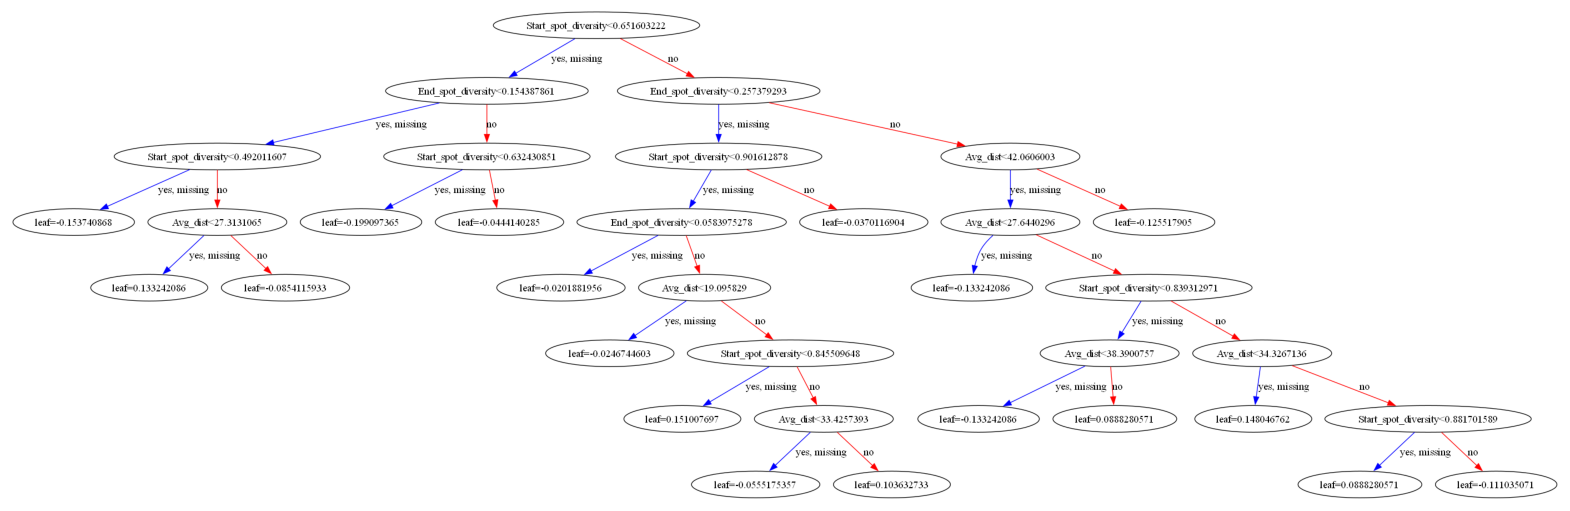

In [5]:
tree_index = 0
xgb_plot_tree(tree_index, xgb_clf)

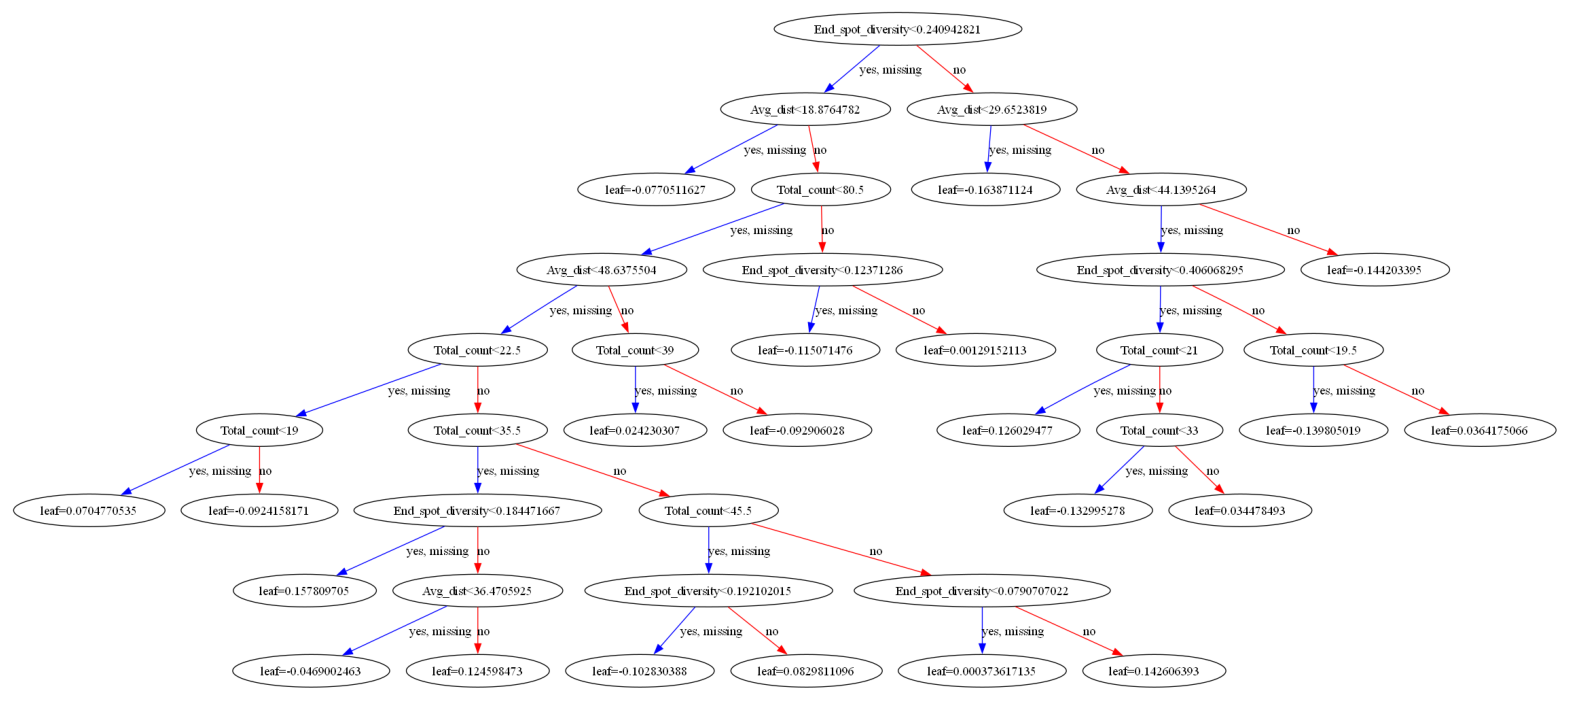

In [51]:
tree_index = 1
xgb_plot_tree(tree_index, xgb_clf)

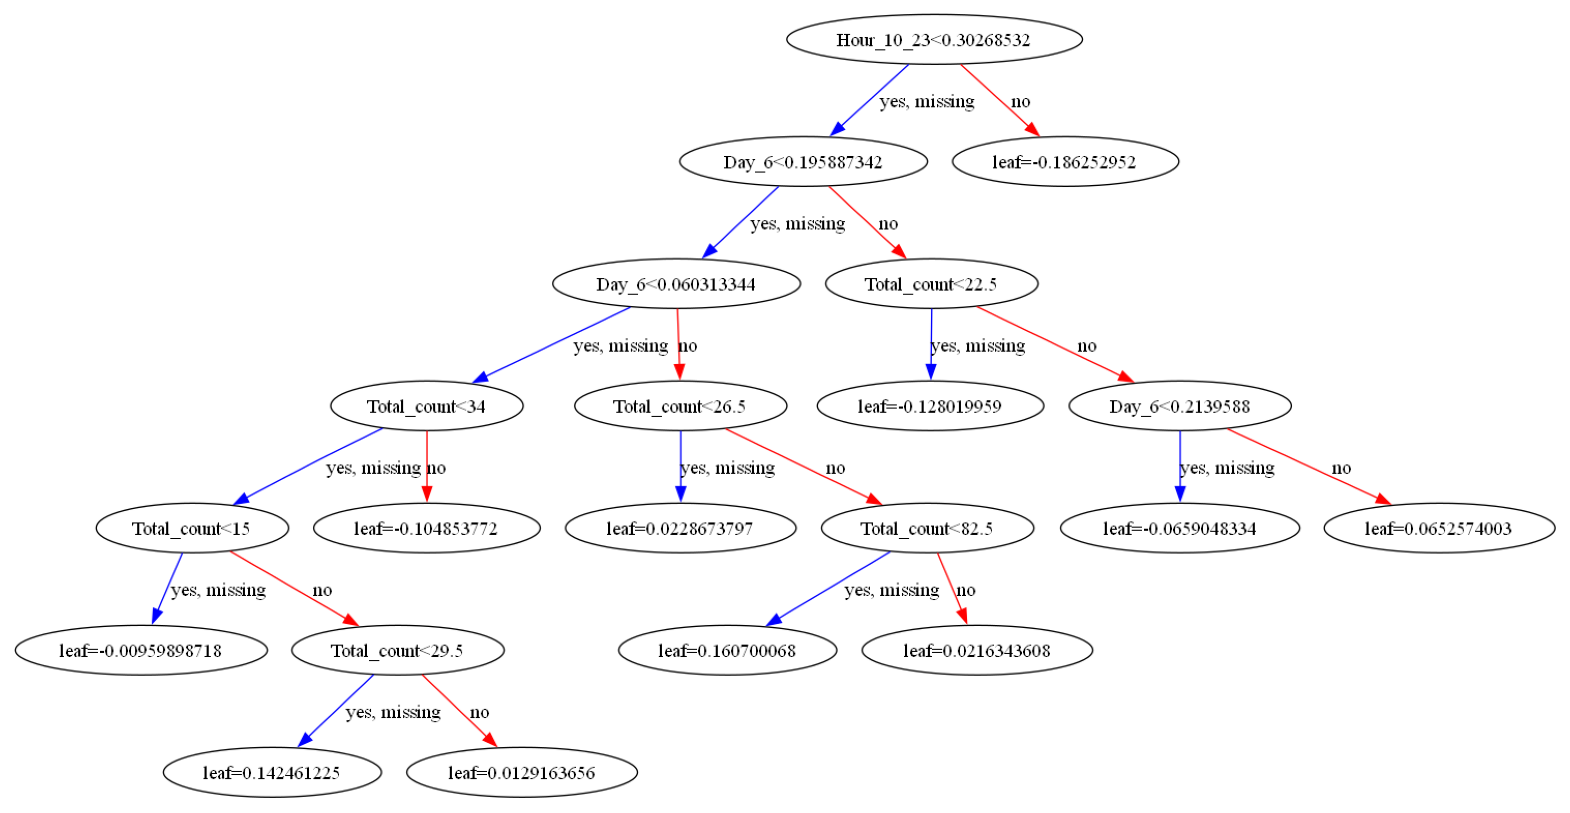

In [52]:
tree_index = 2
xgb_plot_tree(tree_index, xgb_clf)

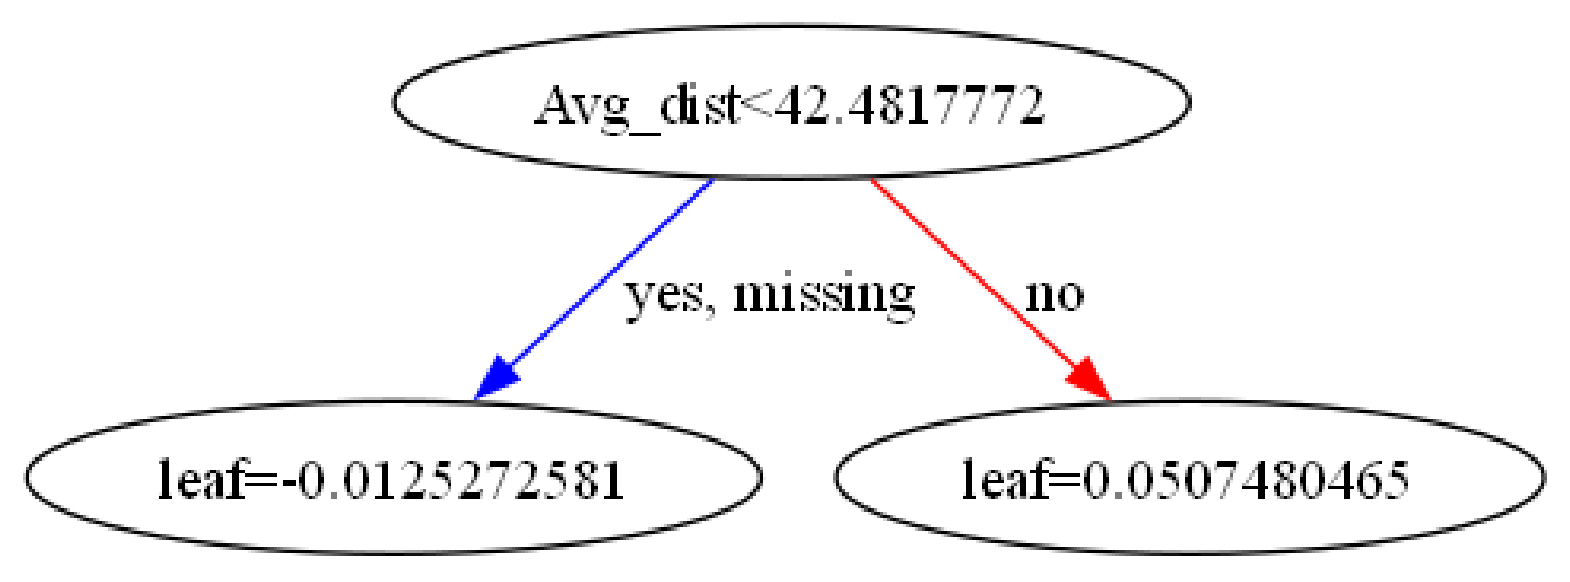

In [53]:
tree_index = 90
xgb_plot_tree(tree_index, xgb_clf)

<Axes: title={'center': 'Feature importance(cover)'}, xlabel='F score', ylabel='Features'>

<Figure size 1000x800 with 0 Axes>

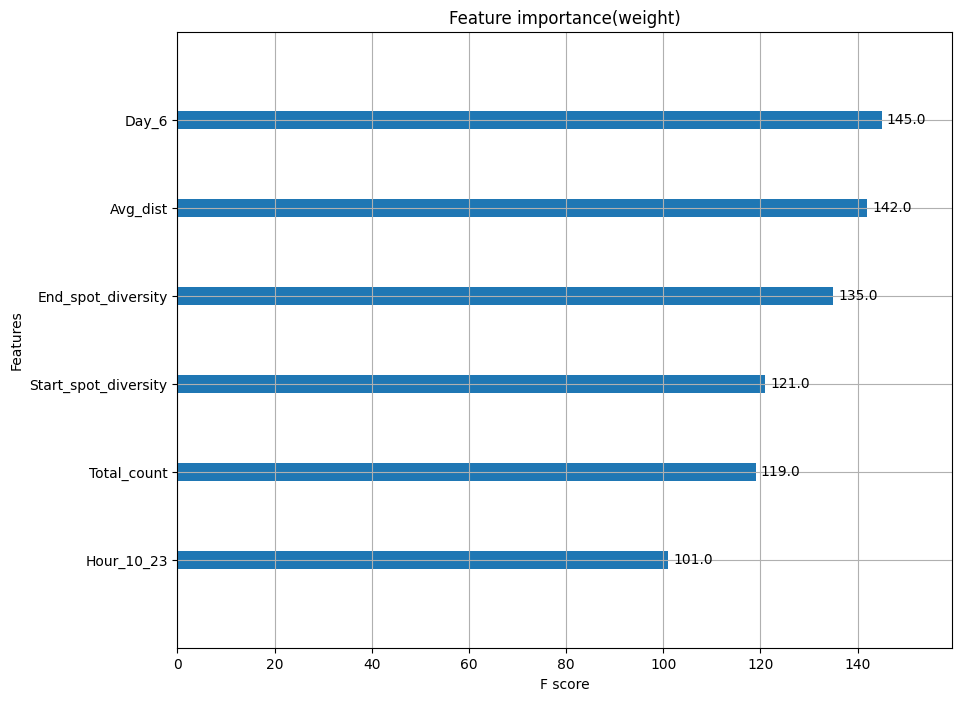

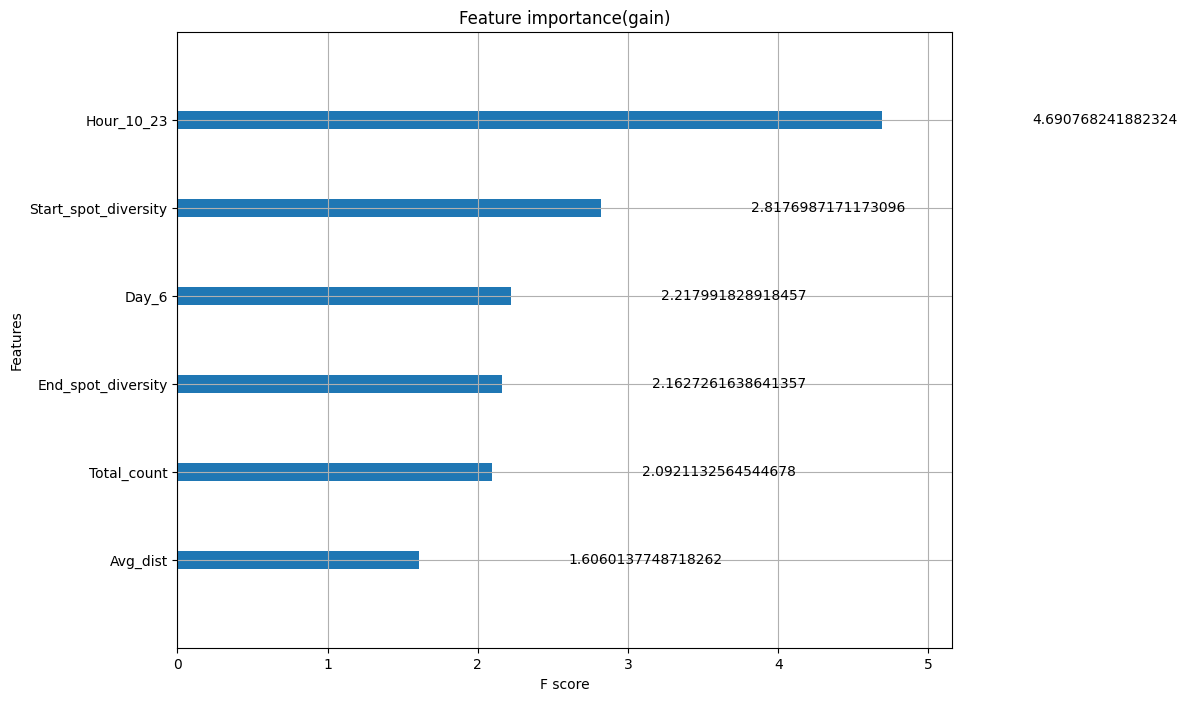

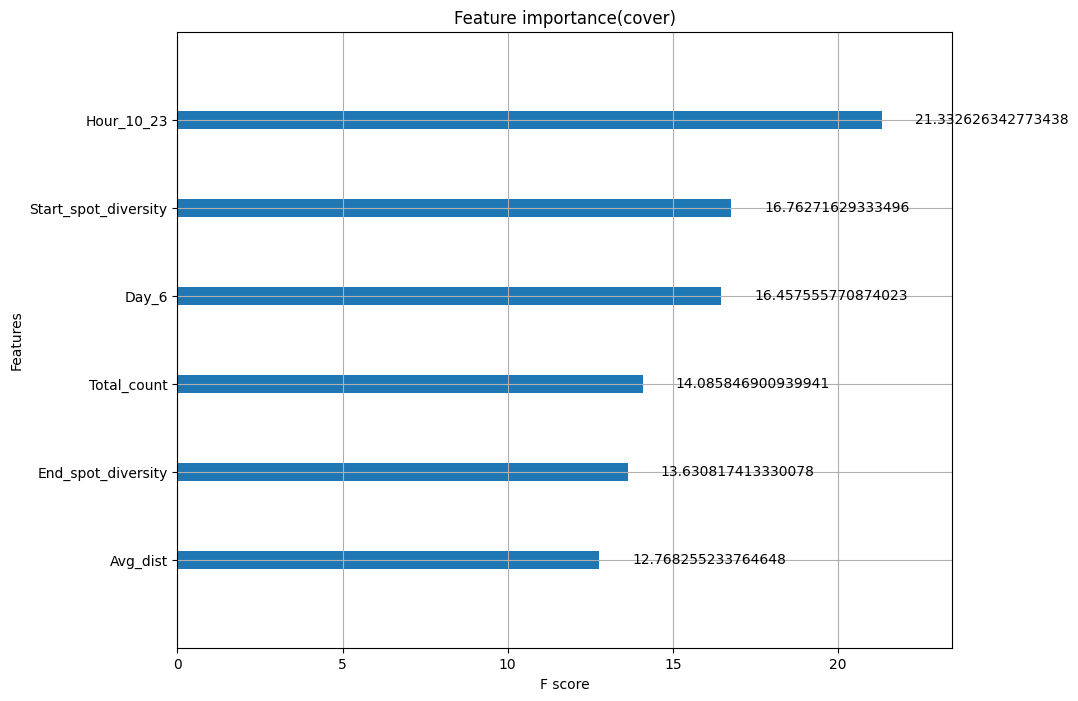

In [40]:
# plot feature importance
rcParams['figure.figsize'] = 10, 8
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_clf, importance_type='weight', title='Feature importance(weight)')
xgb.plot_importance(xgb_clf, importance_type='gain', title='Feature importance(gain)')
xgb.plot_importance(xgb_clf, importance_type='cover', title='Feature importance(cover)')

In [6]:
random_state = 412

df_user = pd.read_csv("output/주제2_사용자데이터_전처리_V2.csv")
# 날짜 데이터 타입 변경
df_user["Start_date"] = pd.to_datetime(df_user["Start_date"])
df_user["End_date"] = pd.to_datetime(df_user["End_date"])

df_spot = pd.read_csv("data/주제2_스팟데이터.csv", encoding='utf-8')

daeri = df_user[df_user['Target']==1]['User_ID'].unique()
nodaeri = df_user[df_user['Target']==0]['User_ID'].unique()

np.random.seed(random_state)

daeri_train= np.random.choice(daeri, int(len(daeri)*0.8), replace=False)
daeri_test = np.setdiff1d(daeri, daeri_train)

nodaeri_train = np.random.choice(nodaeri, int(len(nodaeri)*0.8), replace=False)
nodaeri_test = np.setdiff1d(nodaeri, nodaeri_train)

df_user_train = df_user[df_user['User_ID'].isin(np.concatenate([daeri_train, nodaeri_train]))]
df_user_test = df_user[df_user['User_ID'].isin(np.concatenate([daeri_test, nodaeri_test]))] 


df_spot_cluster = preprocess_cluster(df_user_train, df_spot)

df_user_train = df_user_train.merge(df_spot_cluster, left_on='End_spot_ID', right_on='spot_id', how='left')
df_user_test = df_user_test.merge(df_spot_cluster, left_on='End_spot_ID', right_on='spot_id', how='left')

df_user_train.rename(columns={'Spot_cluster':'End_spot_cluster'}, inplace=True)
df_user_test.rename(columns={'Spot_cluster':'End_spot_cluster'}, inplace=True)

df_centrality = preprocess_centrality(df_user_train)


df_user_train = df_user_train.merge(df_centrality, on='End_spot_ID', how='left')
df_user_test = df_user_test.merge(df_centrality, on='End_spot_ID', how='left')

df_user_test.fillna(0, inplace=True)

df_user_train = preprocess_main(df_user_train)
df_user_test = preprocess_main(df_user_test)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


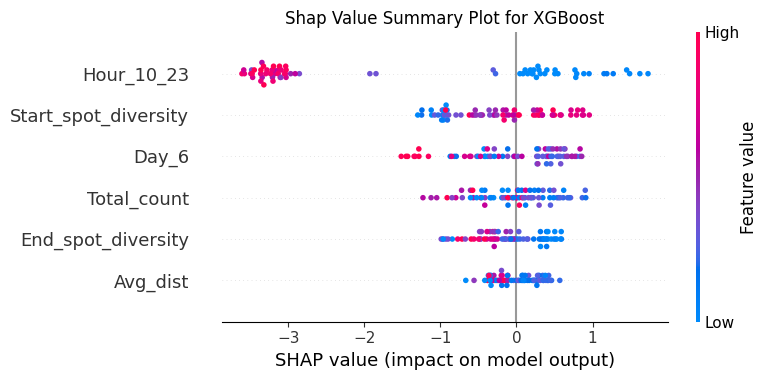

In [7]:
xgb_cols = ['Total_count', 'Day_6', 'Hour_10_23', 'Start_spot_diversity', 'End_spot_diversity', "Avg_dist"]

# 해당 모델에서 사용된 컬럼만 선택
X_test = df_user_test[xgb_cols]  
explainer = shap.TreeExplainer(xgb_clf)

# SHAP 값 계산
shap_values = explainer.shap_values(X_test)

# Binary Classifier의 경우 Positive Class 선택
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# SHAP Summary Plot
plt.title("Shap Value Summary Plot for XGBoost")
shap.summary_plot(
    shap_values, 
    X_test, 
    title=f"SHAP Feature Importance",
    color="royalblue"
)

 - 두 변수간의 상호작용을 관찰할 때 SHAP_value가 0에 몰려 있으면 유의하지 않은 상호작용
 - 0에 몰려있지 않으면 유의한 상호작용으로 해석됨

아래 플롯에서는 Total_count와 Day_6에서 유의한 상호작용이 발생

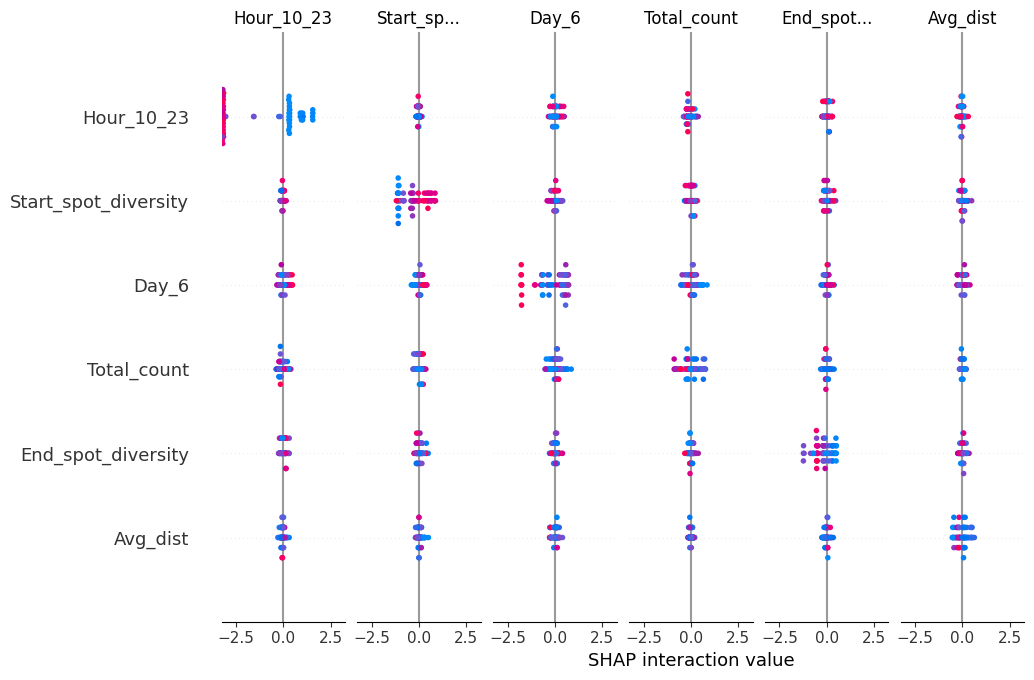

In [8]:
# SHAP interaction values
shap_interaction_values = shap.TreeExplainer(xgb_clf).shap_interaction_values(X_test)
 
# Interaction Summary Plot 
shap.summary_plot(shap_interaction_values, X_test)

# Water Fall for 3 Types of User
- 대리기사 : customer_103
- 직장인 : customer_242
- YOLO Group (여가, 휴가용) : customer_271

Plotting SHAP waterfall plot for Target...
Generating SHAP waterfall plot for User_ID 2...


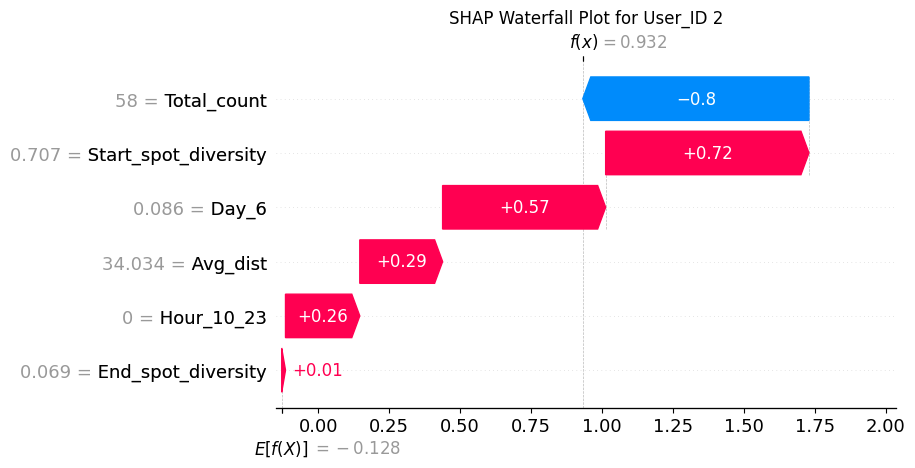

Plotting SHAP waterfall plot for Worker...
Generating SHAP waterfall plot for User_ID 31...


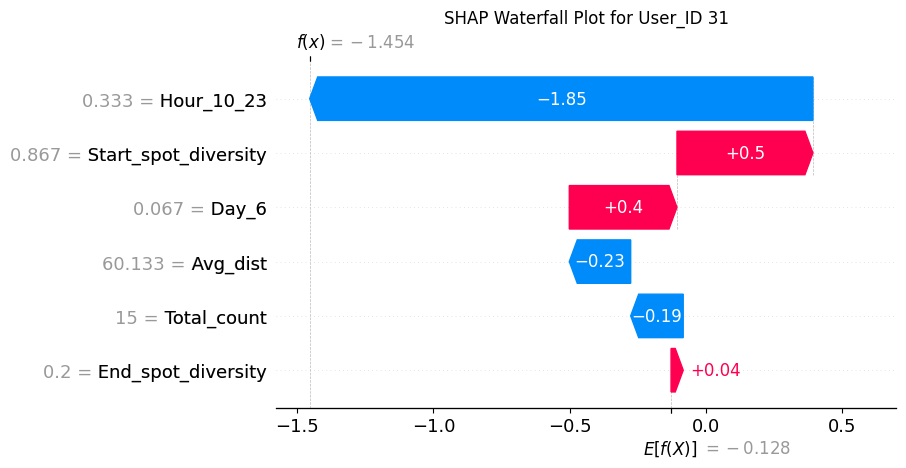

Plotting SHAP waterfall plot for YOLO...
Generating SHAP waterfall plot for User_ID 35...


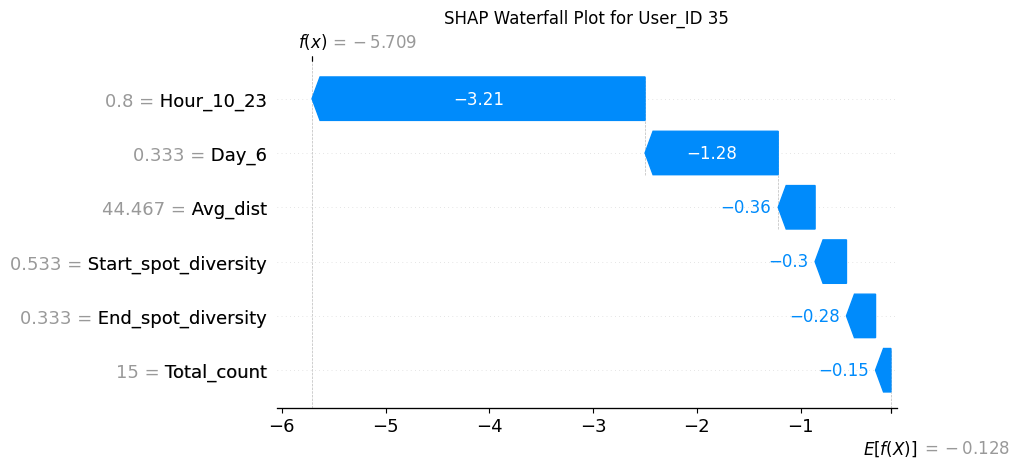

<Figure size 640x480 with 0 Axes>

In [38]:
# get index of user id from test data
user_name = ["Target", "Worker", "YOLO"]
user_id_list = ["customer_103", "customer_242", "customer_271"]

for idx, user_id in enumerate(user_id_list):
    print(f"Plotting SHAP waterfall plot for {user_name[idx]}")
    user_index = df_user_test[df_user_test["User_ID"] == user_id].index[0]
    plot_shap_user(xgb_clf, df_user_test, xgb_cols, user_index)

In [29]:
user_id_list = ["customer_103", "customer_242", "customer_271"]

for idx, user_id in enumerate(user_id_list):
    user_index = df_user_test[df_user_test["User_ID"] == user_id].index[0]

    display(df_user_test.loc[df_user_test["User_ID"] == user_id, xgb_cols])

,Total_count,Day_6,Hour_10_23,Start_spot_diversity,End_spot_diversity,Avg_dist
0,86,0.069767,0.0,0.732558,0.139535,27.255814


,Total_count,Day_6,Hour_10_23,Start_spot_diversity,End_spot_diversity,Avg_dist
31,15,0.066667,0.333333,0.866667,0.2,60.133333


,Total_count,Day_6,Hour_10_23,Start_spot_diversity,End_spot_diversity,Avg_dist
35,15,0.333333,0.8,0.533333,0.333333,44.466667


# Interpretation for each Tree with Booster

In [12]:
# get booster of xgboost
booster = xgb_clf.get_booster()

# predict for user_id_list with only one tree
user_id_list = ["customer_103", "customer_242", "customer_271"]


for idx, user_id in enumerate(user_id_list):
    user_index = df_user_test[df_user_test["User_ID"] == user_id].index[0]

    print(f"Tree prediction: {booster.predict(xgb.DMatrix(df_user_test.loc[[user_index], xgb_cols]))}")
    print(f"Tree prediction with only one tree: {booster.predict(xgb.DMatrix(df_user_test.loc[[user_index], xgb_cols]), ntree_limit=1)}")

Tree prediction: [0.8356722]
Tree prediction with only one tree: [0.5376803]
Tree prediction: [0.18937416]
Tree prediction with only one tree: [0.525885]
Tree prediction: [0.00330572]
Tree prediction with only one tree: [0.45038944]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [14]:
# 트리 예측값 (전체 모델 예측)
full_prediction = booster.predict(xgb.DMatrix(df_user_test.loc[[user_index], xgb_cols]))

# 첫 번째 트리만 사용하여 예측
single_tree_prediction = booster.predict(xgb.DMatrix(df_user_test.loc[[user_index], xgb_cols]), iteration_range=(0, 1))

# 트리에서 출력된 leaf 값들 확인 (단일 트리)
leaf_values = booster.get_dump(with_stats=True)[0]  # 첫 번째 트리의 정보

print("Single tree prediction:", single_tree_prediction)
print("Full model prediction:", full_prediction)

Single tree prediction: [0.45038944]
Full model prediction: [0.00330572]
